In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.linear_model import LinearRegression


In [10]:
data = pd.read_csv("tesla.csv") 


In [11]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-18,76.125999,79.043999,76.115997,78.629997,78.629997,70605000
1,2019-12-19,79.463997,81.370003,79.300003,80.807999,80.807999,90535500
2,2019-12-20,82.057999,82.599998,80.038002,81.117996,81.117996,73763500
3,2019-12-23,82.356003,84.402000,82.000000,83.844002,83.844002,66598000
4,2019-12-24,83.671997,85.094002,82.538002,85.050003,85.050003,40273500
...,...,...,...,...,...,...,...
249,2020-12-14,619.000000,642.750000,610.200012,639.830017,639.830017,52040600
250,2020-12-15,643.280029,646.900024,623.799988,633.250000,633.250000,45223600
251,2020-12-16,628.229980,632.500000,605.000000,622.770020,622.770020,42095800
252,2020-12-17,628.190002,658.820007,619.500000,655.900024,655.900024,56038300


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       254 non-null    object 
 1   Open       254 non-null    float64
 2   High       254 non-null    float64
 3   Low        254 non-null    float64
 4   Close      254 non-null    float64
 5   Adj Close  254 non-null    float64
 6   Volume     254 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 14.0+ KB


In [13]:
data['Date'] = pd.to_datetime(data['Date'])


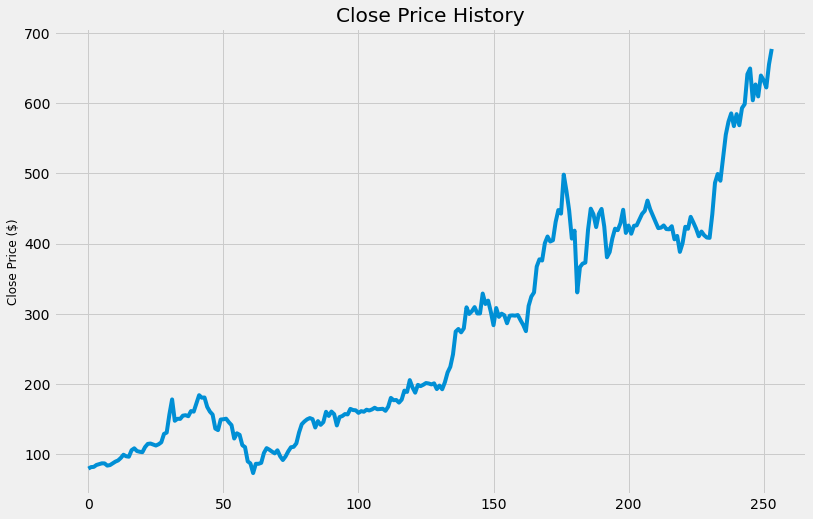

In [14]:
plt.figure(figsize=(12,8))
plt.title('Close Price History')
plt.plot(data['Close'])
plt.ylabel('Close Price ($)',fontsize=12)
plt.show()

In [15]:
#Create a new dataframe with only the 'Close' column
data = data.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [17]:

train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [18]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [19]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [20]:
# the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [21]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [22]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

144/144 [==============================] - 6s 18ms/step - loss: 0.0245


In [23]:

test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [24]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [25]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [26]:
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)

In [27]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

64.5109066445956

<ipython-input-28-c1beac80e8e6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


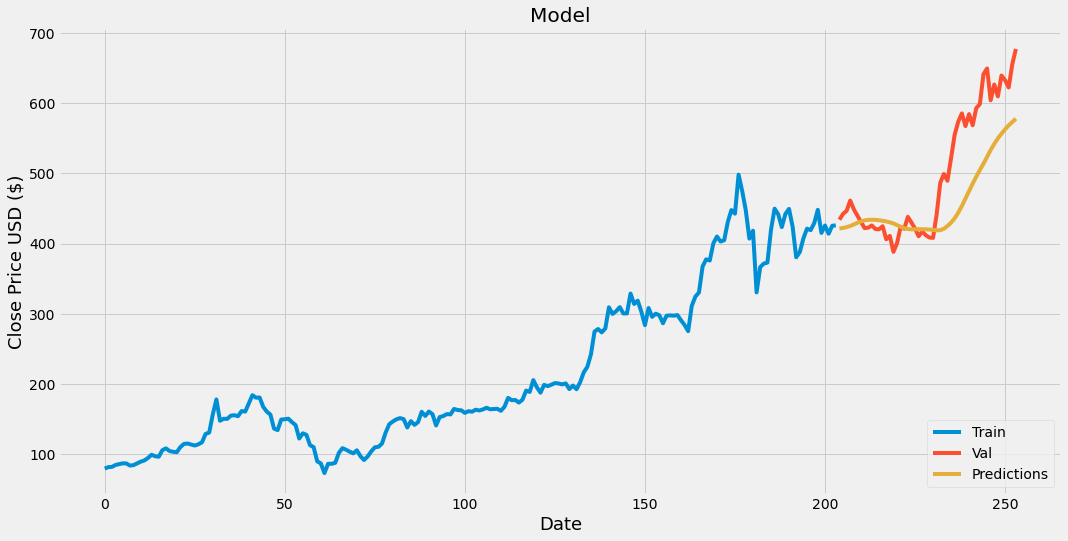

In [28]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [29]:
valid

,Close,Predictions
204,434.000000,421.434265
205,442.299988,422.237061
206,446.649994,423.429352
207,461.299988,425.005676
208,448.880005,427.232147
209,439.670013,429.535126
210,430.829987,431.548889
211,421.940002,433.014374
212,422.640015,433.755432
213,425.790009,433.936432
